# Read the car and non-car samples from the folders

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

% matplotlib inline

/Users/hzhang/MyInstall/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read the car samples from folders
# read samples from all the subfolders

car_samples1 = []

for (root, dirs, files) in os.walk("./vehicles"):
    for dir in dirs:
        path = os.path.join(root,dir)
        for (subroot, subdirs, subfiles) in os.walk(path):
            #car_samples = []
            for filename in subfiles[1:]:   # do not read file .DS_Store
                #images = mpimg.imread(subroot + '/' + filename)
                images = cv2.imread(subroot + '/' + filename)
                car_samples1.append(images)

In [3]:
car_samples2 = []
for (root, dirs, files) in os.walk("./vehicles_video"):
    for dir in dirs:
        path = os.path.join(root,dir)
        for (subroot, subdirs, subfiles) in os.walk(path):
            #car_samples = []
            for filename in subfiles[1:]:   # do not read file .DS_Store
                #images = mpimg.imread(subroot + '/' + filename)
                images = cv2.imread(subroot + '/' + filename)
                car_samples2.append(images)
                
car_samples = []
car_samples.extend(car_samples1)
#car_samples.extend(car_samples2)   # no need to add these samples according to the result.            

In [4]:
notcar_samples1 = []
for (root, dirs, files) in os.walk("./non-vehicles"):
    for dir in dirs:
        path = os.path.join(root,dir)
        for (subroot, subdirs, subfiles) in os.walk(path):
            for filename in subfiles[1:]:   # do not read file .DS_Store
                #images = mpimg.imread(subroot + '/' + filename)
                images = cv2.imread(subroot + '/' + filename)
                notcar_samples1.append(images)

In [5]:
notcar_samples2 = []
for (root, dirs, files) in os.walk("./non-vehicles_video"):
    for dir in dirs:
        path = os.path.join(root,dir)
        for (subroot, subdirs, subfiles) in os.walk(path):
            for filename in subfiles[1:]:   # do not read file .DS_Store
                #images = mpimg.imread(subroot + '/' + filename)
                images = mpimg.imread(subroot + '/' + filename)
                notcar_samples2.append(images)
notcar_samples = []
notcar_samples.extend(notcar_samples1)
notcar_samples.extend(notcar_samples2)

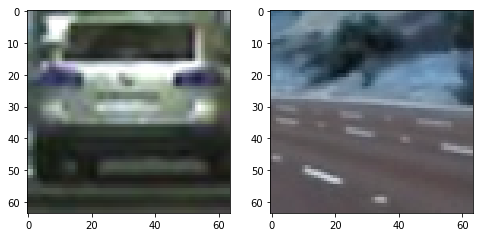

In [6]:
index_car = np.random.randint(len(car_samples))
index_notcar = np.random.randint(len(notcar_samples))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.imshow(car_samples[index_car])
ax2.imshow(notcar_samples[index_notcar])
#plt.savefig('./my_examples/car_not_car.png')

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [8]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [10]:
def convert_color(img, conv='RGB'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB':
        return img

In [11]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one        
        feature_image = convert_color(image, conv=color_space)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Train the classify model

In [12]:
color_space = 'YUV' # Can be RGB, HSV, 'LUV', HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(car_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
print(X_test[0].shape)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C = 14.0)
# Check the training time for the SVC
t=time.time()
print('Start training......')
svc.fit(X_train, y_train)
print('End training......')
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

(6648,)
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6648
Start training......
End training......
7.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9871


In [13]:
#from scipy import misc

def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float64)#/255
    
    #ctrans_tosearch= img[ystart:ystop,0:600,:]
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    #print(np.max(ctrans_tosearch[:,:,2]),np.min(ctrans_tosearch[:,:,2]))
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_prediction = svc.predict(test_features)
            test_score = svc.decision_function(test_features)
            
            
            if test_prediction == 1 and test_score > 1.2:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, box_list

255 0


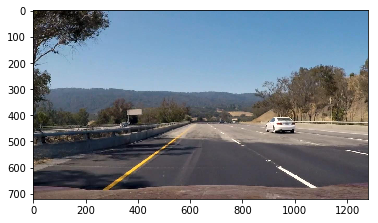

In [14]:
img = mpimg.imread('./test_images/video_img_594.jpg')
plt.imshow(img)
print(np.max(img),np.min(img))

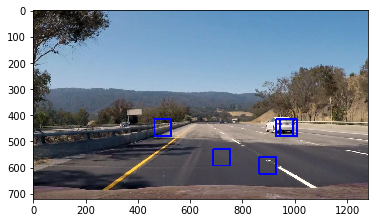

In [22]:
ystart = 400
ystop = 656
scale_group = [1.0]
box_lists = []

for scale in scale_group:
    img_test, bbox_list= find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_lists.extend(bbox_list)
plt.imshow(img_test)
#plt.savefig('./my_examples/sliding_window.jpg')

In [16]:
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

def add_heat(heatmap, box):
    # Iterate through list of bboxes
    #for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold=3):
    # Zero out pixels below the threshold    
    #threshold = np.max((np.max(heatmap)-round(np.max(heatmap)*0.5), 3))
    #print('The threshold is:',threshold)
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [17]:
# function to exclude false positive
def heat_check(img, bbox_list):

    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    for box_list in bbox_list:
        #print(box_list)
        heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold=5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    return heatmap

# Find final boxes from heatmap using label function
'''
heatmap = heat_check(img, box_lists)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize = (16,8))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
'''

"\nheatmap = heat_check(img, box_lists)\nlabels = label(heatmap)\ndraw_img = draw_labeled_bboxes(np.copy(img), labels)\n\nfig = plt.figure(figsize = (16,8))\nplt.subplot(121)\nplt.imshow(draw_img)\nplt.title('Car Positions')\nplt.subplot(122)\nplt.imshow(heatmap, cmap='hot')\nplt.title('Heat Map')\nfig.tight_layout()\n"

In [18]:
# define pipeline

box_lists_frames = []
box_flag = 0

def pipeline(img):
    
    global svc, X_scaler, orient, pix_per_cell, cell_per_block, color_space
    global spatial_size, hist_bins
    global box_lists_frames, box_flag
    
    ystart = 400
    ystop = 656
    scale_group = [1.0, 1.5, 2.0]
    box_lists = []
    
    t1=time.time()
    for scale in scale_group:
        _, bbox_list= find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_lists.extend(bbox_list)
    
    box_lists_frames.append(box_lists)
    t2 = time.time()
    #print(round(t2-t1, 2), 'Seconds to find cars in each frame...')
    
    box_list_select = []
    
    num_frame = 6   # to overlap different frames
    
    if box_flag >= num_frame:
        for i in range(-num_frame,0):
            box_list_select.extend(box_lists_frames[i])
        box_flag = box_flag + 1
    else:
        box_list_select = box_lists
        box_flag = box_flag + 1
    
    heatmap = heat_check(img, box_list_select)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img


In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [20]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip('./project_video.mp4')#.subclip(45,50)  #challenge_video,  project_video
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [37:09<00:01,  1.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 36min 50s, sys: 39.6 s, total: 37min 30s
Wall time: 37min 10s


In [21]:
#help(VideoFileClip)